In [1]:
from fastai.vision.all import *
import os
import pandas as pd
import numpy as np

In [2]:
# Set the correct path to the directory containing train, val, and test folders
path = Path('/kaggle/input/chest-xray-pneumonia/chest_xray')

In [3]:
# Verify that the train and val folders exist
print((path/'train').exists())  # Should print True
print((path/'val').exists())    # Should print True

True
True


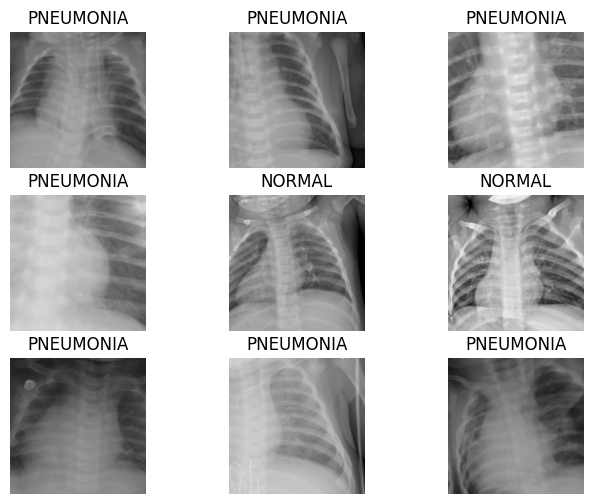

In [4]:
# Set seed for reproducibility
np.random.seed(40)

# Create DataLoaders with the correct directory structure
dls = ImageDataLoaders.from_folder(
    path,
    train='train',      # Uses chest_xray/train folder with NORMAL and PNEUMONIA subfolders
    valid='val',        # Uses chest_xray/val folder with NORMAL and PNEUMONIA subfolders
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
    item_tfms=Resize(224),
    bs=16,
    num_workers=4
)

# Display a batch of images
dls.show_batch(max_n=9, figsize=(8, 6))

In [5]:
# Create learner with ResNet50 backbone
learn = vision_learner(dls, models.resnet50, metrics=accuracy, path=Path('.'))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


In [ ]:
# Find learning rate
learn.lr_find()

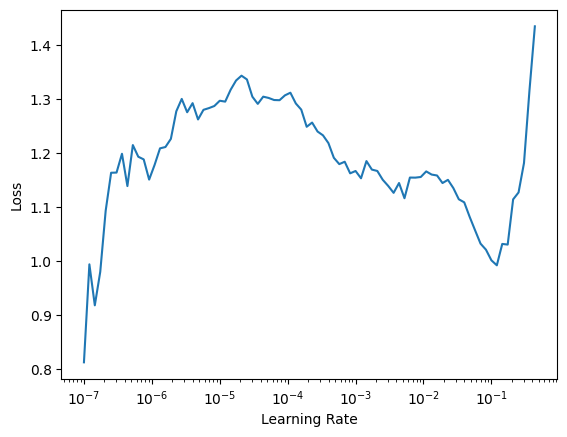

In [12]:
learn.recorder.plot_lr_find(suggestion=True)

In [13]:
# Train the model with frozen layers (only train the head)
lr1 = 1e-2
lr2 = 1e-1
learn.fit_one_cycle(4, slice(lr1, lr2))

epoch,train_loss,valid_loss,accuracy,time
0,1.660331,0.007648,1.000000,00:55
1,1.550586,0.075295,0.937500,00:50
2,0.261898,0.558215,0.750000,00:49
3,0.108614,0.451372,0.750000,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.112534,10.134446,0.562500,01:07
1,0.132364,0.933177,0.625000,01:05
2,0.115512,0.154361,1.000000,01:06
3,0.082903,0.628517,0.562500,01:05
4,0.103657,0.235867,0.875000,01:07
5,0.086364,0.616851,0.687500,01:06
6,0.051233,0.549076,0.812500,01:06
7,0.046893,0.383892,0.750000,01:09
8,0.035598,0.428664,0.812500,01:06
9,0.046354,0.383761,0.750000,01:06


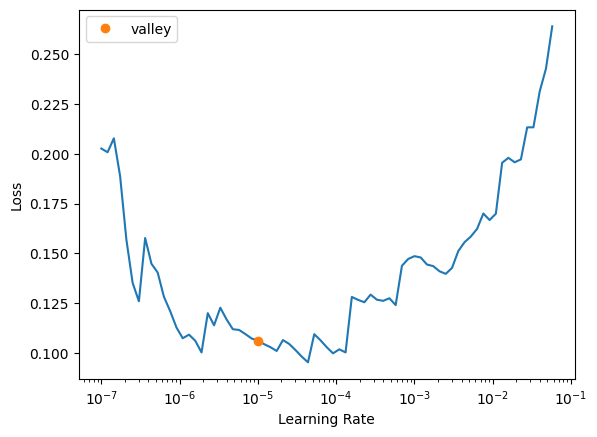

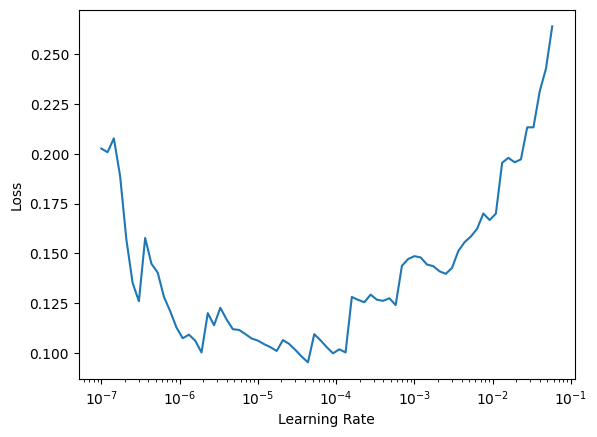

In [15]:
# Fine-tune the whole model
learn.unfreeze()
learn.lr_find()
learn.recorder.plot_lr_find(suggestion=True)
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

In [17]:
# Save the model
learn.save('pneumonia_model')

Path('models/pneumonia_model.pth')

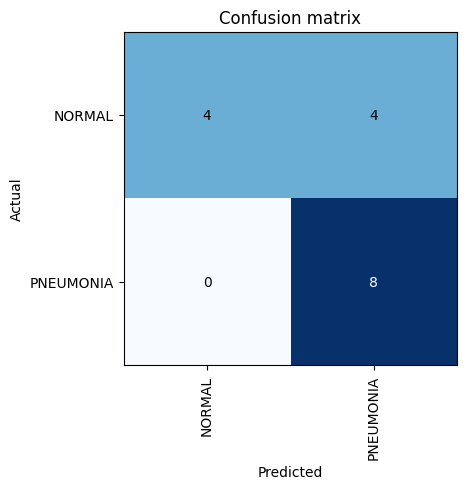

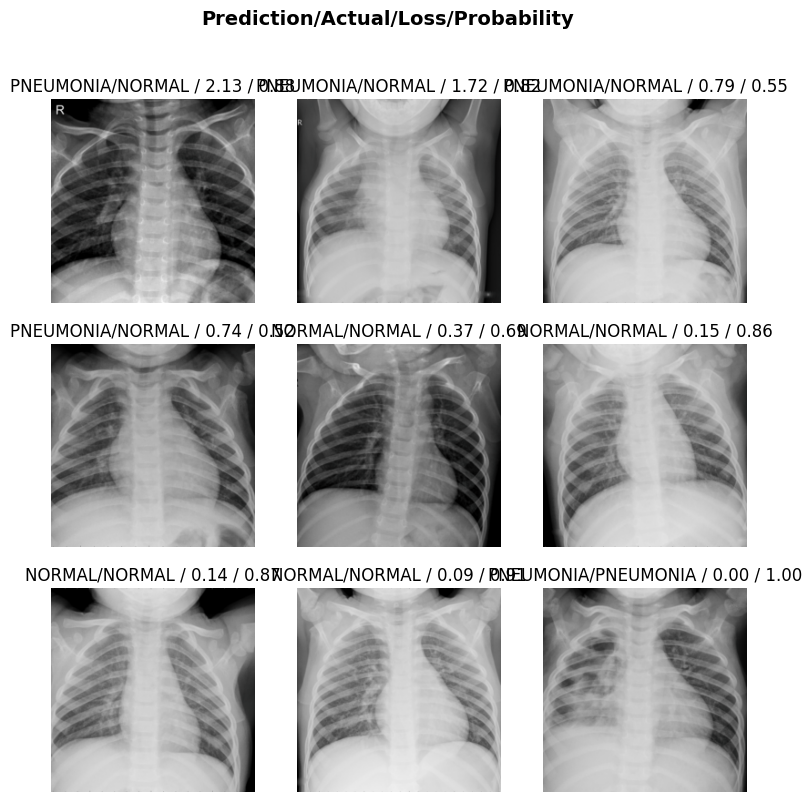

In [18]:
# Create interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9)

In [20]:
# Predict on a single image
img = PILImage.create('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')
pred_class, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred_class}")
print(f"Probability: {probs[pred_idx]:.4f}")

Prediction: PNEUMONIA
Probability: 1.0000
